<a href="https://colab.research.google.com/github/papillonsss-666/Nengo-Code-Example/blob/main/Meeting_9_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install nengo

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import nengo
from nengo.dists import Choice
from nengo.processes import Piecewise
from nengo.utils.ensemble import response_curves, tuning_curves
from nengo.utils.ensemble import sorted_neurons
from nengo.utils.matplotlib import rasterplot

## Input Function

In [18]:
# Define a sine wave function
def sin(t):
  return np.sin(4*t)

## Random Intercept

In [72]:
input = sin

In [73]:
model = nengo.Network()
with model:
    # Input is a sin wave
    input = nengo.Node(input)

    # Our ensemble consists of 100 leaky integrate-and-fire neurons,
    # representing a one-dimensional signal
    ens_1 = nengo.Ensemble(30, dimensions=1)
    ens_1.encoders = Choice([[1]])
    # Here, the intercepts of the neurons are no longer constants.
    # The intercepts have a uniform distribution here
    ens_1.intercepts = nengo.dists.Uniform(0.3, 0.7)

    ens_2 = nengo.Ensemble(30, dimensions=1)
    ens_2.encoders = Choice([[-1]])
    ens_2.intercepts = Choice([0.5])

    ens_3 = nengo.Ensemble(40, dimensions=1)
    ens_3.encoders = Choice([[1]])
    ens_3.intercepts = Choice([-0.5])

    # Connect the input to the population
    nengo.Connection(input, ens_1, synapse = 0.01)
    nengo.Connection(input, ens_2, synapse = 0.01)
    nengo.Connection(input, ens_3, synapse = 0.01)

    # Create probes to collect the data
    input_probe = nengo.Probe(input)

    ens_1_probe = nengo.Probe(ens_1, synapse = 0.01)
    ens_1_spike = nengo.Probe(ens_1.neurons)

    ens_2_probe = nengo.Probe(ens_2, synapse = 0.01)
    ens_2_spike = nengo.Probe(ens_2.neurons)

    ens_3_probe = nengo.Probe(ens_3, synapse = 0.01)
    ens_3_spike = nengo.Probe(ens_3.neurons)

# Create simulator
with nengo.Simulator(model) as sim:
  sim.run(1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

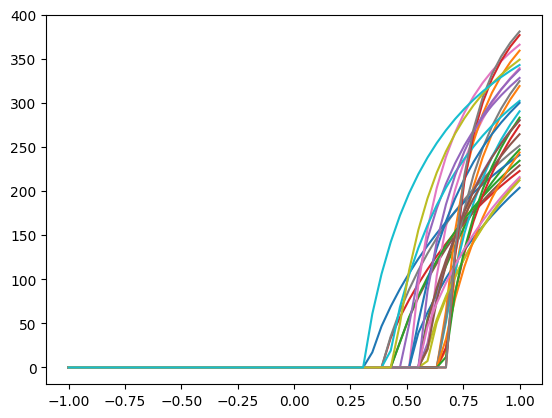

In [74]:
# Tuning curve of the ensemble
# We can see the randomness of intercepts here
plt.figure()
plt.plot(*tuning_curves(ens_1, sim))
plt.show()

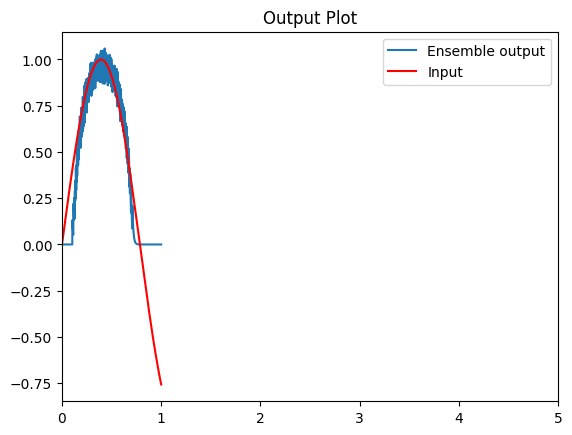

In [75]:
plt.figure()
plt.plot(sim.trange(), sim.data[ens_1_probe], label="Ensemble output")
plt.plot(sim.trange(), sim.data[input_probe], "r", label="Input")
plt.xlim(0, 5)
plt.title("Output Plot")
plt.legend()
plt.show()

(0.0, 5.0)

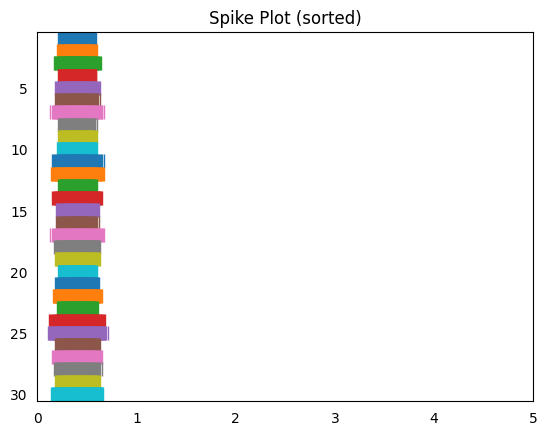

In [76]:
# The spike trains are basically in the same position but have different width
indices = sorted_neurons(ens_1, sim, iterations=250)
plt.figure()
rasterplot(sim.trange(), sim.data[ens_1_spike][:, indices])
plt.title("Spike Plot (sorted)")
plt.xlim(0, 5)

## Neurons Active in a Range

For now I don't think we can create a tuning curve with an upper bound.

## Python Spike Train to CSV

In [90]:
# Get spike from the simulator
spike = sim.data[ens_1_spike]

In [91]:
# Each non-zero entry represents a spike
# Each row represents a timestamp(1ms) and each column represents a neuron
spike

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [109]:
def spikes_to_csv(spikes):
  nrow, ncol = spikes.shape
  result = np.zeros(nrow*ncol).reshape(nrow, ncol)
  for i in range(ncol):
    spike = spikes[:, i]
    spike_time = np.nonzero(spike)[0]
    spike_time = np.append(spike_time, [np.nan]*(spikes.shape[0]-len(spike_time)))
    result[:, i] = spike_time*0.001
  np.savetxt("nengo_data.csv", result, delimiter=",")
  print(result)


In [110]:
spikes_to_csv(spike)

[[0.163 0.206 0.172 ... 0.207 0.14  0.103]
 [0.177 0.214 0.184 ... 0.214 0.148 0.113]
 [0.189 0.221 0.193 ... 0.219 0.155 0.12 ]
 ...
 [  nan   nan   nan ...   nan   nan   nan]
 [  nan   nan   nan ...   nan   nan   nan]
 [  nan   nan   nan ...   nan   nan   nan]]
